In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
categories = ['AbdomenCT', 'ChestCT', 'ChestXR', 'HandXR', 'HeadCT', 'BreastMRI'] # 6 categories of scans
images = [] # where image data set will be loading into (x)
labels = [] # where image labels will be tracked (y)

# Loading data

### Converting scan images to numpy arrays

In [3]:
from PIL import Image
import random

for j in range(5):
    for i in range(10000):
        name = str(i).zfill(6) + '.jpeg'
        img = np.asarray(Image.open(f"raw/{categories[j]}/{name}"))
        images.append(img)
        labels.append(j)

for i in range(8954):
    name = str(i).zfill(6) + '.jpeg'
    img = np.asarray(Image.open(f"raw/BreastMRI/{name}"))
    images.append(img)
    labels.append(5)

images = np.array(images)
labels = np.array(labels)

print(f"Converted all images:\nshape={images.shape}\ndtype={images.dtype}")

Converted all images:
shape=(58954, 64, 64)
dtype=uint8


### Flipping half of all hand x-rays over vertical axis

In [4]:
for i in range(30000, 35000):
    images[i] = np.flip(images[i], axis=1).copy()

### Shuffling images

In [5]:
random.seed(1)
count = len(images) - 1
for i in range(count*10):
    index = i % len(images)
    random_index = random.randint(0, count)
    
    temp = images[random_index].copy()
    images[random_index] = images[index].copy()
    images[index] = temp.copy()
    
    temp = labels[random_index]
    labels[random_index] = labels[index]
    labels[index] = temp

### Partitioning Data into Training, Validation, and Testing Data

In [6]:
# Doing a 60/20/20 split
train_end = int(len(images) * 0.6)
valid_end = int(train_end + len(images) * 0.2)
test_end = len(images)

x_train, y_train = (images[:train_end], labels[:train_end])
x_valid, y_valid = (images[train_end:valid_end], labels[train_end:valid_end])
x_test, y_test = (images[valid_end:test_end], labels[valid_end:test_end])

print(f"Training Data: \t\tx :: {x_train.shape}\t\ty :: {y_train.shape}")
print(f"Validation Data: \tx :: {x_valid.shape}\t\ty :: {y_valid.shape}")
print(f"Testing Data: \t\tx :: {x_test.shape}\t\ty :: {y_test.shape}")
print("\n-------------- Data is ready for model --------------")

Training Data: 		x :: (35372, 64, 64)		y :: (35372,)
Validation Data: 	x :: (11790, 64, 64)		y :: (11790,)
Testing Data: 		x :: (11792, 64, 64)		y :: (11792,)

-------------- Data is ready for model --------------


# Building CNN model

In [34]:
layers = tf.keras.layers
model = tf.keras.models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=7, activation="relu", padding="valid", input_shape=[64,64,1]))

model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"))

model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"))
model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(units=32, activation="relu"))
layers.Dropout(0.5)
model.add(layers.Dense(units=16, activation="relu"))
layers.Dropout(0.5)
model.add(layers.Dense(units=6, activation="softmax"))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 58, 58, 64)        3200      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 conv2d_14 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 128)      

In [36]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [37]:
history = model.fit(x_train, y_train, batch_size = 128, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
277/277 [==============================] - 137s 494ms/step - loss: 0.3789 - accuracy: 0.9081 - val_loss: 0.1206 - val_accuracy: 0.9575
Epoch 2/5
277/277 [==============================] - 138s 498ms/step - loss: 0.0289 - accuracy: 0.9930 - val_loss: 0.0228 - val_accuracy: 0.9942
Epoch 3/5
277/277 [==============================] - 143s 517ms/step - loss: 0.0146 - accuracy: 0.9958 - val_loss: 0.0285 - val_accuracy: 0.9946
Epoch 4/5
277/277 [==============================] - 148s 534ms/step - loss: 0.0172 - accuracy: 0.9954 - val_loss: 0.0135 - val_accuracy: 0.9961
Epoch 5/5
277/277 [==============================] - 146s 527ms/step - loss: 0.0091 - accuracy: 0.9969 - val_loss: 0.0125 - val_accuracy: 0.9966


In [38]:
score = model.evaluate(x_test, y_test)

369/369 [==============================] - 13s 35ms/step - loss: 0.0124 - accuracy: 0.9967


In [39]:
print('Total loss on Testing Set:', score[0])
print('Accuracy of Testing Set:', score[1])

Total loss on Testing Set: 0.012436643242835999
Accuracy of Testing Set: 0.9966926574707031


In [40]:
x_new = x_test[:5]
y_proba = model.predict(x_new)
y_proba.round(2)

1/1 [==============================] - 0s 64ms/step


array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [41]:
y_pred = np.argmax(model.predict(x_new), axis=-1)
y_pred

1/1 [==============================] - 0s 27ms/step


array([4, 5, 3, 4, 3])

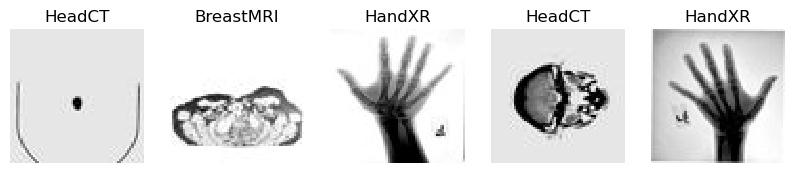

In [42]:
categories = ['AbdomenCT', 'ChestCT', 'ChestXR', 'HandXR', 'HeadCT', 'BreastMRI'] # 6 categories of scans

plt.figure(figsize=(10, 10))
for index, image in enumerate(x_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(categories[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

In [8]:
cnn = tf.keras.models.Sequential() #initializing the CNN
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation="relu", padding = "same", input_shape=[64, 64, 1])) #Convolution 1
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 1
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding = "same")) #Convolution 2
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding = "same")) #Convolution 3
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 2
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding = "same")) #Convolution 4
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding = "same")) #Convolution 5
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 3
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding = "same")) #Convolution 6
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding = "same")) #Convolution 7
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 4
cnn.add(tf.keras.layers.Flatten()) #Flaterning
cnn.add(tf.keras.layers.Dense(units=32, activation="relu"))#Full Connection1
tf.keras.layers.Dropout(0.5)
cnn.add(tf.keras.layers.Dense(units=16, activation="relu"))#Full Connection2
tf.keras.layers.Dropout(0.5)
cnn.add(tf.keras.layers.Dense(units= 6, activation= "softmax"))#Output layer

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       7

In [10]:
cnn.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [11]:
history = cnn.fit(x_train, y_train, batch_size = 128, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5


2024-12-18 01:07:11.541252: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


277/277 [==============================] - 222s 801ms/step - loss: 0.2851 - accuracy: 0.9014 - val_loss: 0.0350 - val_accuracy: 0.9931
Epoch 2/5
277/277 [==============================] - 237s 857ms/step - loss: 0.0278 - accuracy: 0.9928 - val_loss: 0.0126 - val_accuracy: 0.9959
Epoch 3/5
277/277 [==============================] - 241s 870ms/step - loss: 0.0950 - accuracy: 0.9805 - val_loss: 0.0505 - val_accuracy: 0.9894
Epoch 4/5
277/277 [==============================] - 241s 869ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.0081 - val_accuracy: 0.9965
Epoch 5/5
277/277 [==============================] - 242s 873ms/step - loss: 0.0118 - accuracy: 0.9958 - val_loss: 0.0072 - val_accuracy: 0.9969


In [12]:
score = cnn.evaluate(x_test, y_test)

369/369 [==============================] - 22s 61ms/step - loss: 0.0095 - accuracy: 0.9970


In [14]:
print('Total loss on Testing Set:', score[0])

Total loss on Testing Set: 0.0095386216416955


In [13]:
print('Accuracy of Testing Set:', score[1])

Accuracy of Testing Set: 0.9970318675041199


In [26]:
x_new = x_test[:10]
y_proba = cnn.predict(x_new)
y_proba.round(2)

1/1 [==============================] - 0s 45ms/step


array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [27]:
y_pred = np.argmax(cnn.predict(x_new), axis=-1)
y_pred

1/1 [==============================] - 0s 47ms/step


array([4, 5, 3, 4, 3, 4, 4, 0, 3, 2])

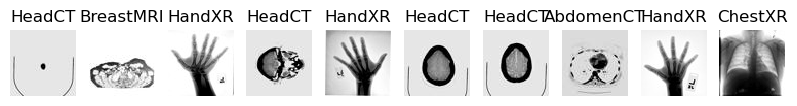

In [29]:
categories = ['AbdomenCT', 'ChestCT', 'ChestXR', 'HandXR', 'HeadCT', 'BreastMRI'] # 6 categories of scans

plt.figure(figsize=(10, 10))
for index, image in enumerate(x_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(categories[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()